test shape : (100, 96)


Perturbing data: 100%|██████████| 480000/480000 [00:02<00:00, 186764.72it/s]


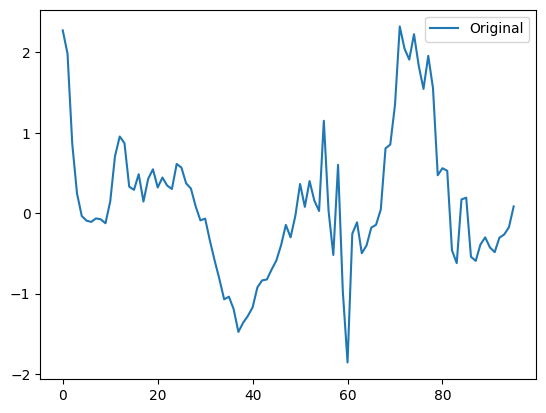

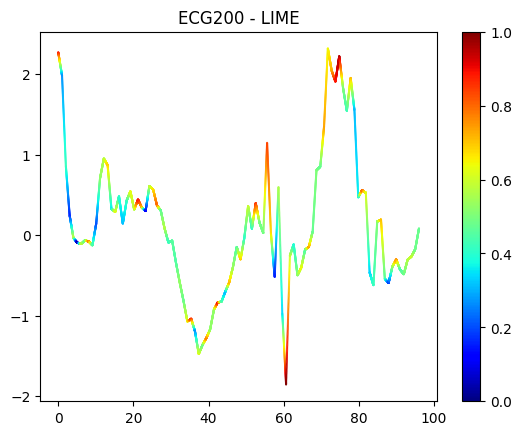

class0 :  [-0.00832231  0.03855599  0.03898071  0.02947797  0.0396295   0.03176358
  0.03191109  0.00777783 -0.01591728  0.02281653 -0.00917266 -0.03024823
  0.03449829  0.00617514  0.0134985   0.00774331  0.01774201 -0.02869455
 -0.02290923 -0.0080898  -0.05463958  0.02377775 -0.01322281  0.01741768
 -0.020653    0.00332403 -0.02226794 -0.0399696  -0.0175141  -0.00370774
  0.01357534  0.01972297 -0.04584043  0.02366904 -0.02564451 -0.02340831
  0.0120633  -0.0664913   0.00550211  0.00535912 -0.03319583  0.02935722
 -0.0115327  -0.01027159 -0.00717218  0.06028209 -0.0277003  -0.00624528
 -0.04905316 -0.00497096  0.04595491 -0.02988451 -0.00417515  0.03623297
 -0.00871347  0.01383937 -0.01499805 -0.01281264 -0.02473458  0.04194442
  0.00995801  0.0028055   0.01138251  0.04524034 -0.0230557   0.
  0.0082897   0.01738165  0.00019358  0.01950704  0.00228034  0.04152519
  0.01919663  0.00959972  0.00563251  0.02000805 -0.00614333 -0.01275482
  0.00815913  0.03271859 -0.03754283  0.04588099 

In [2]:
import numpy as np

from saliencyserieslab.explainers.shap_explainer import ShapExplainer, KernelShapExplainer
from saliencyserieslab.explainers.leftist_explainer import LeftistExplainer
from saliencyserieslab.explainers.lime_explainer import LimeExplainer
from saliencyserieslab.plotting import plot_graph, plot_weighted
from saliencyserieslab.classifier import SktimeClassifier
from saliencyserieslab.load_data import UcrDataset

dataset = "ECG200" # ECG200 SwedishLeaf
modelpath = f"../models/rocket_{dataset}_1"
expname = "LIME"
idx = 99 # 100 / 99


ucr = UcrDataset(
    name=dataset,
    float_dtype=32,
)

test_x, test_y = ucr.load_split("test")
print("test shape : {}".format(test_x.shape))

ts = test_x[idx]

model = SktimeClassifier()

model.load_pretrained_model(modelpath)

if expname == "LEFTIST":

    explainer = LeftistExplainer(
        model=model,
        random_background=test_x,
        perturbation_ratio=0.5,
        num_samples=5_000,
        segment_size=5,
    )

elif expname == "LIME":

    explainer = LimeExplainer(
        model=model,
        perturbation_ratio=0.5,
        num_samples=5_000,
    )

elif expname == "SHAPLEY":

    explainer = ShapExplainer(
        model=model,
        x_background=np.zeros((1,ts.shape[0]))
    )

elif expname == "KERNELSHAP":

    explainer = KernelShapExplainer(
        model=model,
        x_background=np.zeros((1,ts.shape[0]))
    )

w = explainer.explain_instance(ts)

plot_graph(ts, show=True)
plot_weighted(
    ts=ts, 
    w=w,
    modelname=modelpath.split("/")[-1].split("_")[0],
    explainername=expname,
    dataset=dataset,
    show=True,
    colormap="jet",
    )

In [3]:
import numpy as np

from saliencyserieslab.explainers.shap_explainer import ShapExplainer, KernelShapExplainer
from saliencyserieslab.explainers.leftist_explainer import LeftistExplainer
from saliencyserieslab.explainers.lime_explainer import LimeExplainer
from saliencyserieslab.plotting import plot_graph, plot_weighted
from saliencyserieslab.classifier import SktimeClassifier
from saliencyserieslab.load_data import UcrDataset

dataset = "ECG200" # ECG200 SwedishLeaf
modelpath = f"../models/rocket_{dataset}_1"
expname = "LIME"
idx = 99 # 100 / 99


ucr = UcrDataset(
    name=dataset,
    float_dtype=32,
)

test_x, test_y = ucr.load_split("test")

/home/eirik/anaconda3/envs/ssl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from saliencyserieslab.explainers.leftist.LEFTIST import LEFTIST
from saliencyserieslab.explainers.leftist.learning_process.SHAP_learning_process import SHAPLearningProcess
from saliencyserieslab.explainers.leftist.learning_process.LIME_learning_process import LIMELearningProcess
from saliencyserieslab.explainers.leftist.timeseries.segmentator.uniform_segmentator import UniformSegmentator
from saliencyserieslab.explainers.leftist.timeseries.transform_function.mean_transform import MeanTransform
from saliencyserieslab.explainers.leftist.timeseries.transform_function.rand_background_transform import RandBackgroundTransform
from saliencyserieslab.explainers.leftist.timeseries.transform_function.straightline_transform import StraightlineTransform

learning_process_name = "SHAP"
random_state = 42
transform_name = "rand_background"
nb_interpretable_feature = test_x.shape[1]
idx = 55

ts_x = test_x[idx]
ts_y = test_y[idx]

model = SktimeClassifier()

model.load_pretrained_model(modelpath)

if learning_process_name == 'SHAP':
    learning_process = SHAPLearningProcess(
        ts_x,
        model,
        external_dataset=test_x[0].reshape(1,-1),
        )
    
else:
    learning_process = LIMELearningProcess(random_state)


if transform_name == 'mean':
    transform = MeanTransform(ts_x)
elif transform_name == 'straight_line':
    transform = StraightlineTransform(ts_x)
else:
    transform = RandBackgroundTransform(ts_x)
    transform.set_background_dataset(test_x)


segmentator = UniformSegmentator(nb_interpretable_feature)
leftist = LEFTIST(transform,segmentator,model,learning_process)

explanations = leftist.explain(
    1000, 
    ts_x, 
    explanation_size=test_x.shape[1],
    idx_label=ts_y,
    )

for i in range(len(explanations)):
    print('class{} : '.format(i),explanations[i][0])

class0 :  [-0.02548102  0.01433269  0.04341069 -0.04346593  0.02828883  0.07647426
 -0.03639391 -0.02505862 -0.02635057 -0.00445269 -0.02189509 -0.00602422
 -0.03160538  0.02812038  0.03602974 -0.05329955 -0.00094618  0.01471845
  0.          0.00373309 -0.01340862  0.02830369 -0.01541143  0.07629456
 -0.01600789  0.00316848  0.01629002 -0.00378044  0.05888205 -0.01523333
  0.01227252  0.01912011 -0.0310474  -0.00796084  0.01129634  0.10987208
 -0.02042    -0.05272822 -0.00300875  0.0078913  -0.00576583  0.00085887
 -0.00283719 -0.02668352 -0.00860063  0.01221673 -0.057279   -0.01384003
  0.0013055  -0.03671514  0.00838551 -0.00516388  0.06334261  0.00249287
  0.01897016  0.02304532  0.0028749  -0.01933109 -0.05389614 -0.02652433
 -0.01590436 -0.00902674  0.03798867  0.04194638  0.06470644  0.09185707
  0.00212335  0.07762604 -0.05304833 -0.01719076 -0.05029558 -0.03166397
 -0.0744945   0.0003206   0.01102533 -0.00283975  0.01909146 -0.03823811
 -0.01973698  0.04405795 -0.02448232 -0.0

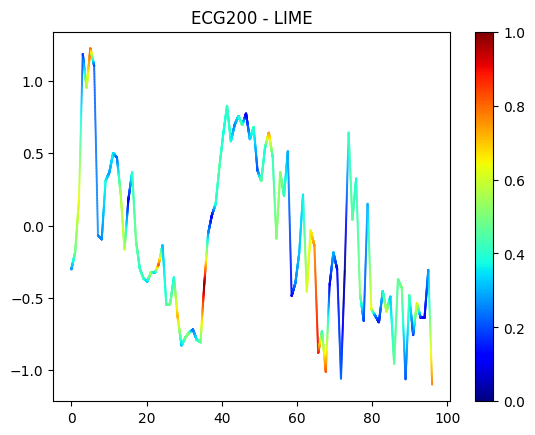

In [5]:
from saliencyserieslab.plotting import plot_weighted
import numpy as np

w = np.interp(explanations[0][0], (explanations[0][0].min(), explanations[0][0].max()), (0, 1)).tolist()

plot_weighted(
    ts=ts_x, 
    w=w,
    modelname=modelpath.split("/")[-1].split("_")[0],
    explainername=expname,
    dataset=dataset,
    show=True,
    colormap="jet",
    )

In [5]:
a = np.array([1, 2, 3]).reshape(1,-1)
a

array([[1, 2, 3]])

In [29]:
c = 30
a = 128 // c

a

4

In [2]:
import numpy as np

# Original vector of size 30
original_vector = np.array([0.1, 0.2, 0.3])

# Target size
target_size = 20

# Generate the indices for interpolation
interpolated_vector = np.interp(
    np.linspace(0, len(original_vector) - 1, target_size),
    np.arange(len(original_vector)),
    original_vector
)

print(interpolated_vector)
print(interpolated_vector.shape)

[0.1        0.11052632 0.12105263 0.13157895 0.14210526 0.15263158
 0.16315789 0.17368421 0.18421053 0.19473684 0.20526316 0.21578947
 0.22631579 0.23684211 0.24736842 0.25789474 0.26842105 0.27894737
 0.28947368 0.3       ]
(20,)
